In [1]:
import torch 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from cdft.dft1d import dft_core
from cdft.lj_eos import lj_eos

device = torch.device('cpu')

pi = np.pi
kB = 1.380649e-23
NA = 6.02214076e23

plt.rcParams.update({'text.usetex':True, 
'font.family':'serif', 
'font.size':18, 
})

In [2]:
sigma = 3.849
epsilon = 94.45
parameters = {'sigma':sigma, 'epsilon':epsilon}

In [3]:
T = 77.4
eos = lj_eos(parameters, T)
P = torch.hstack((torch.arange(1e-7,1e-6,0.5e-7,dtype=torch.float64),torch.arange(1e-6,1e-5,0.5e-6,dtype=torch.float64),
                 torch.arange(1e-5,1e-4,0.5e-5,dtype=torch.float64),torch.arange(1e-4,1e-3,0.5e-4,dtype=torch.float64),
                 torch.arange(1e-3,1e-2,0.5e-3,dtype=torch.float64), torch.arange(1e-2,1e-1,0.5e-2,dtype=torch.float64),
                 torch.arange(0.1,0.7,0.01,dtype=torch.float64), torch.arange(0.7,0.85,0.005,dtype=torch.float64),
                 torch.arange(0.85,0.9,0.003,dtype=torch.float64), torch.arange(0.9,0.93,0.002,dtype=torch.float64),
                 torch.arange(0.93,1.0,0.0015,dtype=torch.float64)))*1e5

bulk_density = torch.empty_like(P)

bulk_density[0] = eos.density(P[0],'vap')
for i in range(1,len(P)):
    bulk_density[i] = eos.density(P[i],bulk_density[i-1])

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_34830/1789170785.py:1: SyntaxWarning: invalid escape sequence '\s'
  nist = pd.read_csv('data/N2_77K_NIST.txt', sep='\s+', skiprows=1,


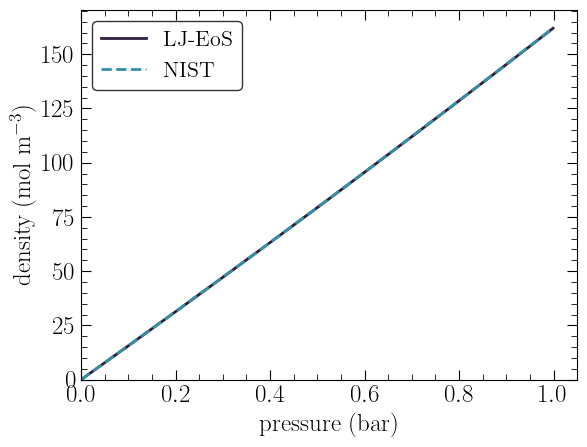

In [4]:
nist = pd.read_csv('data/N2_77K_NIST.txt', sep='\s+', skiprows=1, 
                    usecols=[1,2], names=['Pressure (bar)','Density (mol/m3)'])

colors = sns.color_palette("mako")

plt.plot(P*1e-5, bulk_density*1e30/(NA), '-', color=colors[0], linewidth=2.0, label='LJ-EoS')
plt.plot(nist['Pressure (bar)'],nist['Density (mol/m3)'], '--', color=colors[3], linewidth=2.0, label='NIST')
plt.xlabel(r'pressure (bar)', fontsize=18)
plt.ylabel(r'density (mol m$^{-3}$)', fontsize=18)
plt.xlim([0.0,None])
plt.ylim([0.0,None])
plt.minorticks_on()
plt.tick_params(direction='in',right=True, top=True)
plt.tick_params(labelsize=18)
plt.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
# xticks = np.arange(0, 1e4,10)
# yticks = np.arange(0,16.1,4)
plt.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=7, bottom=True, top=True, left=True, right=True)
# plt.xticks(xticks)
# plt.yticks(yticks)
plt.legend(fontsize=16, frameon=True, edgecolor='k')

In [5]:
H = 20.0
system_size = H+10
points = int(system_size*100)

def steele(z,sigma,epsilon):
    rhos = 0.114
    Delta = 3.35
    return 2.0*pi*rhos*epsilon*sigma**2*Delta*(0.40*(sigma/z)**10-(sigma/z)**4-sigma**4/(3.0*Delta*(z+0.610*Delta)**3))

sigma_s = 3.40
epsilon_s = 28.0
sigma_is = 0.5*(sigma+sigma_s) 
epsilon_is = np.sqrt(epsilon*epsilon_s)

dft = dft_core(parameters, T, system_size, points, device)
Vext = torch.zeros(dft.points, dtype=torch.float64)
kin = 500
kout = int(system_size*100-kin)
Vext[0:kin] = np.inf
Vext[kout:] = np.inf
Vext[kin:kout] = steele(dft.z[kin:kout]-5, sigma_is, epsilon_is)+steele(H-(dft.z[kin:kout]-5), sigma_is, epsilon_is)

In [6]:
dft.initial_condition(bulk_density[0],Vext)
Nads = torch.empty_like(P)
Ndes = torch.empty_like(P) 
Omega_ads = torch.empty_like(P)
Omega_des = torch.empty_like(P)

for i in range(len(P)):
    dft.equilibrium_density_profile(bulk_density[i],fmt='ASWB',solver='fire',
                                    alpha0=0.1,dt=0.01,tol=1e-6,logoutput=False)
    Nads[i] = dft.total_molecules 
    Omega_ads[i] = dft.Omega
    print(dft.it,dft.error.numpy(),1e-5*P[i].numpy(),Nads[i].numpy())   
    if np.isnan(dft.error.numpy()): break

128 1.027823926258227e-07 1.0000000000000001e-07 1.7837826943836214e-05
125 8.449347457137198e-07 1.5000000000000002e-07 2.6765439379957672e-05
125 7.17097197112912e-07 2.0000000000000002e-07 3.56989044224324e-05
107 1.7968292519749266e-08 2.5e-07 4.463824649413515e-05
107 2.4689638848437227e-08 3.0000000000000004e-07 5.358339767847598e-05
106 8.560132025380016e-07 3.5e-07 6.253431725659e-05
106 7.465279469394584e-07 4.0000000000000003e-07 7.149117529766408e-05
106 6.623068952843562e-07 4.5000000000000003e-07 8.045389967951063e-05
106 5.953471461265372e-07 5e-07 8.942249824131046e-05
106 5.407040467108981e-07 5.5e-07 9.839697881801068e-05
106 4.951595445077769e-07 6.000000000000001e-07 0.0001073773492492228
106 4.5652874850546626e-07 6.499999999999999e-07 0.00011636361738418627
106 4.2327595707063414e-07 7e-07 0.00012535579108451618
106 3.9429014920327274e-07 7.5e-07 0.00013435387822575764
106 3.68747677040235e-07 8.000000000000001e-07 0.00014335788669861662
106 3.4602495107962394e-07 

In [7]:
Ndes[-1] = dft.total_molecules
Omega_des[-1] = dft.Omega
for i in range(len(P)-2,-1,-1):
    dft.equilibrium_density_profile(bulk_density[i],fmt='ASWB',solver='fire',
                                    alpha0=0.1,dt=0.01,tol=1e-6,logoutput=False)
    Ndes[i] = dft.total_molecules 
    Omega_des[i] = dft.Omega
    print(dft.it,dft.error.numpy(),1e-5*P[i].numpy(),Ndes[i].numpy())   
    if np.isnan(dft.error.numpy()): break

137 7.58140665850308e-07 0.9975 0.2740828370545482
137 8.088149730761624e-07 0.9960000000000001 0.2740724897114779
137 8.110620214301298e-07 0.9945 0.2740621237527159
137 8.121671521028933e-07 0.9930000000000002 0.2740517396139672
137 8.132321714418063e-07 0.9915 0.27404133724611696
137 8.142842182676188e-07 0.9900000000000002 0.27403091659018514
137 8.153242541663965e-07 0.9885 0.27402047758666576
137 8.163526311727606e-07 0.9870000000000002 0.27401002017576515
137 8.173698079650483e-07 0.9855 0.27399954429740087
137 8.183761998771395e-07 0.9840000000000002 0.2739890498911972
137 8.193722960173833e-07 0.9825 0.2739785368964974
137 8.203584882416636e-07 0.9810000000000002 0.27396800525233816
137 8.213353206879282e-07 0.9795 0.2739574548974699
137 8.223033057245674e-07 0.9780000000000002 0.27394688577034454
137 8.232630349261247e-07 0.9765 0.2739362978091207
137 8.242150438746238e-07 0.9750000000000002 0.27392569095164276
137 8.251598989802883e-07 0.9735 0.2739150651354653
137 8.2609827

In [8]:
Neq = np.copy(Nads)
Omega_eq = np.copy(Omega_ads)
for i in range(len(P)):
    if Omega_des[i] < Omega_ads[i]:
        Omega_eq[i] = Omega_des[i]
        Neq[i] = Ndes[i]

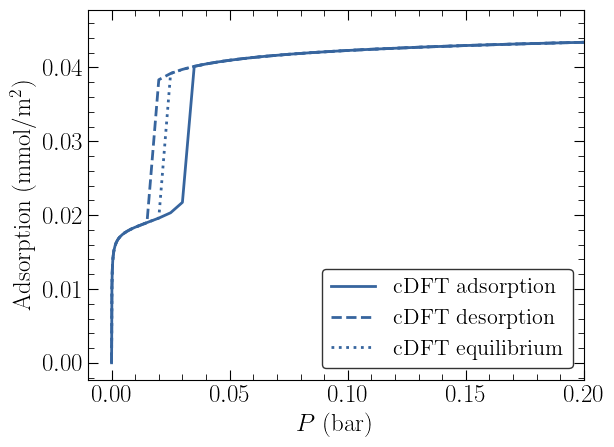

In [21]:
colors = sns.color_palette("mako")

plt.plot(P*1e-5, (1e23/NA)*Nads, '-', color=colors[2], linewidth=2.0, label='cDFT adsorption')
plt.plot(P*1e-5, (1e23/NA)*Ndes, '--', color=colors[2], linewidth=2.0, label='cDFT desorption')
plt.plot(P*1e-5, (1e23/NA)*Neq, ':', color=colors[2], linewidth=2.0, label='cDFT equilibrium')
plt.xlabel(r'$P$ (bar)', fontsize=18)
plt.ylabel(r'Adsorption (mmol/m$^2$)', fontsize=18)
plt.xlim([-0.01,0.2])
# plt.ylim([0.0,2000])
plt.minorticks_on()
plt.tick_params(direction='in',right=True, top=True)
plt.tick_params(labelsize=18)
plt.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
plt.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=7, bottom=True, top=True, left=True, right=True)
plt.legend(fontsize=16, frameon=True, edgecolor='k')

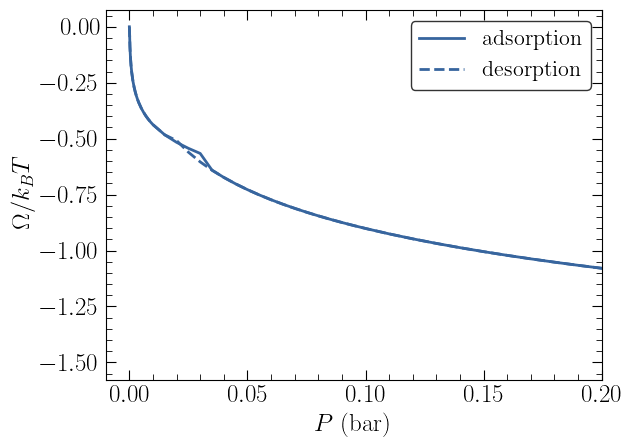

In [22]:
colors = sns.color_palette("mako")

plt.plot(P*1e-5, Omega_ads, '-', color=colors[2], linewidth=2.0, label='adsorption')
plt.plot(P*1e-5, Omega_des, '--', color=colors[2], linewidth=2.0, label='desorption')
plt.xlabel(r'$P$ (bar)', fontsize=18)
plt.ylabel(r'$\Omega/k_B T$', fontsize=18)
plt.xlim([-0.01,0.2])
# plt.ylim([0.0,2000])
plt.minorticks_on()
plt.tick_params(direction='in',right=True, top=True)
plt.tick_params(labelsize=18)
plt.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
plt.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=7, bottom=True, top=True, left=True, right=True)
plt.legend(fontsize=16, frameon=True, edgecolor='k')